In [1]:
import numpy as np
import matplotlib.pyplot as plt
from fun import *

In [2]:
gammar = 1.4 
Nx = 600
k = 2
NumGLP = 2 * k + 1
dimPk = k + 1
NumEq = 3
CFL = 0.15
flux_type = 1
Limit_type = 2

In [3]:
# 获取高斯积分点和权重
point, weight = get_GLP(NumGLP)

In [4]:
# 网格
xa = 0
xb = 1
hx = (xb - xa)/Nx
h1 = 0.5*hx

xc = np.linspace(xa + h1, xb - h1, Nx)

# 初始场
U = np.zeros((NumEq, Nx, NumGLP)) # [rho, rho*u, E]
for i in range(Nx):
    for j in range(NumGLP):
        x = xc[i] + h1 * point[j]
        U[0,i,j] = rho0(x)
        U[1,i,j] = rho0(x) * u0(x)
        U[2,i,j] = p0(x) / (gammar -1) + 0.5 * rho0(x) * u0(x) * u0(x)
        
x = np.linspace(xa, xb, Nx+1)

In [5]:
# 基函数在高斯点的值和导数
# 基函数定义为 1, X, X^2-1/3, ...
#  -1 < X < 1
phi_gauss = np.zeros((NumGLP, dimPk))
phi_grad_gauss = np.zeros((NumGLP, dimPk))
phi_r = np.zeros(dimPk)
phi_l = np.zeros(dimPk)
mass = np.asarray([1, 1/3, 4/45])
for i in range(NumGLP):
    phi_gauss[i,0] = 1
    phi_grad_gauss[i,0] = 0

    phi_gauss[i,1] = point[i]
    phi_grad_gauss[i,1] = 1 / h1

    phi_gauss[i,2] = point[i] ** 2 - 1/3
    phi_grad_gauss[i,2] = 2 * point[i] / h1

phi_r[0] = 1; phi_r[1] = 1; phi_r[2] = 2 / 3
phi_l[0] = 1; phi_l[1] = -1; phi_l[2] = 2 / 3

In [6]:
# 将初始场投影到基函数上，获取基函数系数初始值
uh = np.zeros((NumEq, Nx, dimPk))
weight_matrix = np.diag(weight)
# for i in range(Nx):
#     for j in range(dimPk):
#         for k in range(NumGLP):
#             for m in range(NumEq):
#                 uh[m,i,j] += 0.5 * weight_matrix[k,k] * U[m,i,k] * phi_gauss[k,j]
for m in range(NumEq):
    uh[m] = 0.5 * U[m] @ weight_matrix @ phi_gauss
for d in range(dimPk):
    uh[:,:,d] /= mass[d]

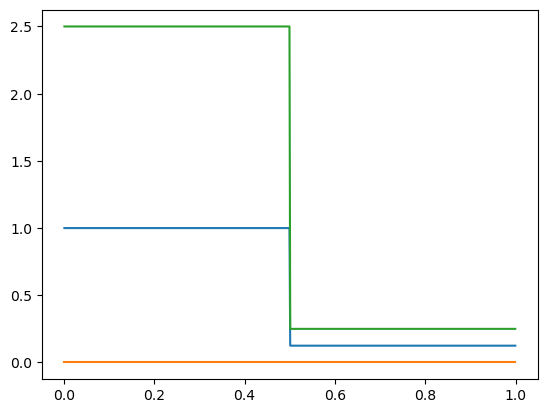

In [7]:
u = get_u(uh,phi_gauss)

plt.plot(xc, u[0,:,0])
plt.plot(xc, u[1,:,0])
plt.plot(xc, u[2,:,0])

0.00021128856368212914
0.0004225771273642583
0.0006338656910463874
0.0008451542547285166
0.0010564428184106458
0.001267731382092775
0.0014790199457749042
0.0016903085094570334
0.0019015970731391626
0.0021128856368212916
0.0023241742005034208
0.00253546276418555
0.002746751327867679
0.0029580398915498084
0.0031693284552319376
0.0033806170189140668
0.003591905582596196
0.003803194146278325
0.004014482709960454
0.004225771273642583
0.004437059837324712
0.0046483484010068415
0.004859636964688971
0.0050709255283711
0.005282214092053229
0.005493502655735358
0.0057047912194174875
0.005916079783099617
0.006127368346781746
0.006338656910463875
0.006549945474146004
0.0067612340378281335
0.006972522601510263
0.007183811165192392
0.007395099728874521
0.00760638829255665
0.007817676856238779
0.008028965419920908
0.008240253983603037
0.008451542547285166
0.008662831110967295
0.008874119674649425
0.009085408238331554
0.009296696802013683
0.009507985365695812
0.009719273929377941
0.00993056249306007
0

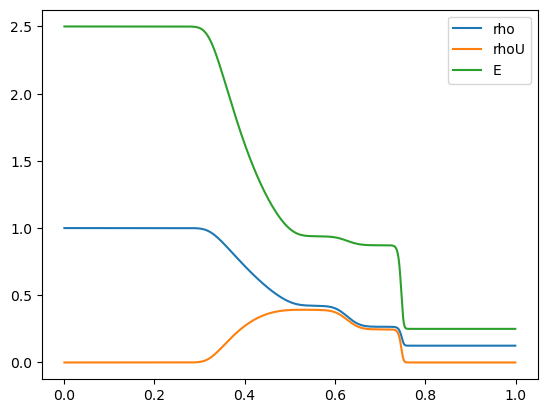

In [8]:
# 计算波速alpha
bcL = bcR = 2
alpha = 1
CFL = 0.15
t = 0.0
for i in range(Nx):
    alpha1, alpha2 = wavespeed(uh[:,i,0])
    alpha = max(alpha, alpha1, alpha2)
dt = CFL * hx / alpha

while t < 0.14:

    du = Lh(uh,bcL,bcR,phi_gauss,phi_grad_gauss,weight,phi_l,phi_r,flux_type,hx,mass)
    uh1 = uh + dt * du
    uh1 = TVD_Limiter_P1(uh1,bcL,bcR,h1)

    du = Lh(uh1,bcL,bcR,phi_gauss,phi_grad_gauss,weight,phi_l,phi_r,flux_type,hx,mass)
    uh2 = 0.75 * uh + 0.25 * (uh1 + dt * du)
    uh2 = TVD_Limiter_P1(uh2,bcL,bcR,h1)

    du = Lh(uh2,bcL,bcR,phi_gauss,phi_grad_gauss,weight,phi_l,phi_r,flux_type,hx,mass)
    uh = (1/3) * uh + (2/3) * (uh2 + dt * du)
    uh = TVD_Limiter_P1(uh,bcL,bcR,h1)

    t += dt
    print(t)

rho = uh[0,:,0]
rhou = uh[1,:,0]
E = uh[2,:,0]
plt.plot(xc, rho, label='rho')
plt.plot(xc, rhou, label='rhoU')
plt.plot(xc, E, label='E')
plt.legend()

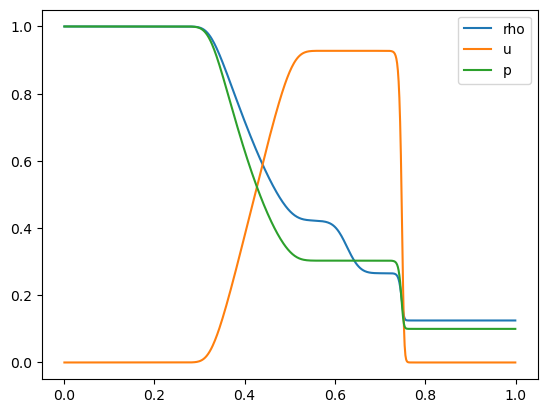

In [9]:
rho = uh[0,:,0]
rhou = uh[1,:,0]
E = uh[2,:,0]
u = rhou / rho
p = (gammar - 1) * (E - 0.5 * rho * u ** 2)
plt.plot(xc, rho, label='rho')
plt.plot(xc, u, label='u')
plt.plot(xc, p, label='p')
plt.legend()